In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import *
from sklearn.naive_bayes import *
from sklearn.tree import *
from sklearn.model_selection import *
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

df = pd.read_csv('data.csv', header = 0)
df = df.drop(['id'], axis=1)
diagnosis = df['diagnosis']
df['catNB'] = pd.factorize(df['diagnosis'].values)[0]
dfLabels = df['catNB'] 
labels = ['M', "B"]

features = ['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean'] # Features I will use 

bestAccuracy = 0.0
bestParams = None
bestCombination = []
bestDF = None
bestModel = None

k = 10 # Number of splits
maxRange = 7
C_Range = [0.0001, 0.001, 0.01, 0.1, 1] #[0.01, 0.1, 1, 10, 100, 1000]

def rSubset(arr, r): 
    # return list of all subsets of length r 
    # to deal with duplicate subsets use  
    # set(list(combinations(arr, r))) 
    return list(combinations(arr, r)) 

Non-Poly Kernel Tests:

In [11]:
for nNumberOfFeatures in range(2, len(features)+1):
    possibleCombinations = rSubset(features, nNumberOfFeatures) # Creates complete list of all combinations of
    for combination in possibleCombinations:
        currentDF = pd.DataFrame()
        i = 0
        for feature in combination:
            currentDF.insert(i, feature, df[feature].to_list(), True)
            i += 1

        x = currentDF
        y = dfLabels

        model = SVC(C=100, kernel = 'poly')
        
        # Set up the grid of parameters 
        hyperParams = {'degree': range(2, maxRange),
                    'gamma': ['scale', 'auto']}
        # Train the model in the grid search
        kFolds = StratifiedKFold(n_splits = k, shuffle = True, random_state = 0)
        
        for param in ['degree']:
          maxDepthRange = range(2, maxRange)
          trainScores, testScores = validation_curve(model, x, y, \
                      param_name = param, param_range = maxDepthRange, \
                      cv = kFolds, scoring = 'accuracy')
          trainScoresMean = np.mean(trainScores, axis=1)
          trainScoresStd = np.std(trainScores, axis=1)
          testScoresMean = np.mean(testScores, axis=1)
          testScoresStd = np.std(testScores, axis=1)

          filteredTestScoresMean = [] # Include all test scores that are within STD of train scores mean
          filteredTestScoresMeanIndex = [] 
          for i in range(0, len(trainScoresMean)):
              if testScoresMean[i] + testScoresStd[i] >= trainScoresMean[i]:
                  filteredTestScoresMean.append(testScoresMean[i])
                  filteredTestScoresMeanIndex.append(i)

          print("Test Scores Left:", len(filteredTestScoresMean))

          bestScore = 0.0
          bestScoreIndex = 0
          for i in range(0, len(filteredTestScoresMean)):
              if filteredTestScoresMean[i] > bestScore:
                  bestScore = filteredTestScoresMean[i]
                  bestScoreIndex = filteredTestScoresMeanIndex[i]

          if len(filteredTestScoresMean) == 0:
              bestScore = testScoresMean[search.best_params_[param] -1 ]
              bestScoreIndex = search.best_params_[param] - 1
          
          highestAccuracy = (bestScore, bestScoreIndex) # Percent, depth 

          bestDegree = bestScoreIndex + 2

          print("Accuracy with", combination, ":", highestAccuracy[0])
          print("Degree:", bestDegree, '\n')

        if highestAccuracy[0] > bestAccuracy:
            bestAccuracy = highestAccuracy[0]
            bestCombination = combination
            bestDF = currentDF
            bestParams = bestDegree
            bestModel = SVC(C=100, kernel="poly", degree=bestDegree)

            confusion = np.zeros((2,2))
            scores = cross_val_score(bestModel, x, y, cv = kFolds)
            predicted = cross_val_predict(bestModel, x, y, cv = kFolds)
            accuracy = scores.mean()
            confusion = confusion_matrix(y, predicted)
            confDF = pd.DataFrame(confusion)
            confDF.columns = labels
            confDF.index = labels

            fig, ax = plt.subplots() # figsize=(6,10)
            plt.title('Confusion matrix with best accuracy (Stratified K-Fold [K=10])\nwith Decision Tree')
            ax = sns.heatmap(confDF, annot = True, square=True, linewidth=3)
            fig.savefig('Best Heatmap Stratified K-Fold with KNN.png')
            plt.close()

Test Scores Left: 5
Accuracy with ('radius_mean', 'perimeter_mean') : 0.8875626566416039
Degree: 2 

Test Scores Left: 5
Accuracy with ('radius_mean', 'area_mean') : 0.8928884711779448
Degree: 2 

Test Scores Left: 5
Accuracy with ('radius_mean', 'compactness_mean') : 0.892825814536341
Degree: 4 

Test Scores Left: 5
Accuracy with ('radius_mean', 'concavity_mean') : 0.9103696741854638
Degree: 6 

Test Scores Left: 5
Accuracy with ('radius_mean', 'concave points_mean') : 0.8998433583959902
Degree: 6 

Test Scores Left: 5
Accuracy with ('perimeter_mean', 'area_mean') : 0.8858709273182956
Degree: 4 

Test Scores Left: 5
Accuracy with ('perimeter_mean', 'compactness_mean') : 0.8910401002506264
Degree: 6 

Test Scores Left: 5
Accuracy with ('perimeter_mean', 'concavity_mean') : 0.8981203007518797
Degree: 5 

Test Scores Left: 5
Accuracy with ('perimeter_mean', 'concave points_mean') : 0.8893170426065163
Degree: 6 

Test Scores Left: 5
Accuracy with ('area_mean', 'compactness_mean') : 0.8928

In [12]:
print("Best Accuracy:", bestAccuracy)
print("Feature Combination of Best Accuracy:", bestCombination)
print("Best Parameters of Best Accuracy:", bestParams)

Best Accuracy: 0.9349310776942357
Feature Combination of Best Accuracy: ('compactness_mean', 'concavity_mean', 'concave points_mean')
Best Parameters of Best Accuracy: 3


[0.91378446 0.93139098 0.93493108 0.93142231 0.92440476 0.91563283]


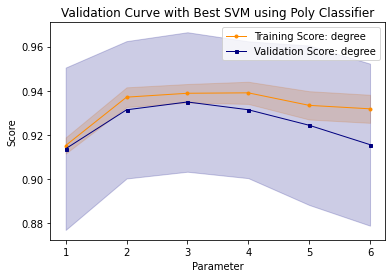

In [13]:
x = bestDF
y = dfLabels
model = bestModel

fig = plt.figure()

for param in ['degree']:
  maxDepthRange = range(1, maxRange)
  trainScores, testScores = validation_curve(model, x, y, \
              param_name = param, param_range = maxDepthRange, \
              cv = kFolds, scoring = 'accuracy')
  trainScoresMean = np.mean(trainScores, axis=1)
  trainScoresStd = np.std(trainScores, axis=1)
  testScoresMean = np.mean(testScores, axis=1)
  testScoresStd = np.std(testScores, axis=1)

  print(testScoresMean)

  colors = ['darkorange', 'navy']

  plt.plot(maxDepthRange, trainScoresMean, label = 'Training Score: ' + param, \
          color = colors[0], lw = 1, marker = 'o', markersize = 3)
  plt.fill_between(maxDepthRange, trainScoresMean - trainScoresStd, \
                  trainScoresMean + trainScoresStd, alpha = 0.2, \
                  color = colors[0], lw = 1)
  plt.plot(maxDepthRange, testScoresMean, label = 'Validation Score: ' + param, \
          color = colors[1], lw = 1, marker = 's', markersize = 3)
  plt.fill_between(maxDepthRange, testScoresMean - testScoresStd, \
                  testScoresMean + testScoresStd, alpha = 0.2, \
                  color = colors[1], lw = 1)

  '''
  plt.title("Validation Curve with Best KNN Classifier using " + param)
  plt.xlabel(param + ' Parameter')
  plt.ylabel("Score")
  plt.legend(loc="best")

  plt.show()
  fig.savefig('KNN Validation Curve ' + param + '.png')
  '''

plt.title("Validation Curve with Best SVM using Poly Classifier")
plt.xlabel('Parameter')
plt.ylabel("Score")
plt.legend(loc="best")

plt.show()
fig.savefig('SVC with Poly Validation Curve.png')

scores = cross_val_score(model, x, y, cv = kFolds)
predicted = cross_val_predict(model, x, y, cv = kFolds)
accuracy = scores.mean()
confusion = confusion_matrix(y, predicted)
confDF = pd.DataFrame(confusion)
confDF.columns = labels
confDF.index = labels

fig, ax = plt.subplots() # figsize=(6,10)
plt.title('Confusion Matrix with Best Accuracy (SVM with Poly)')
ax = sns.heatmap(confDF, annot = True, square=True, linewidth=3)
fig.savefig('Best Heatmap SVM with Poly.png')
plt.close()



bestDF:      compactness_mean  concavity_mean  concave points_mean
0             0.27760         0.30010              0.14710
1             0.07864         0.08690              0.07017
2             0.15990         0.19740              0.12790
3             0.28390         0.24140              0.10520
4             0.13280         0.19800              0.10430
..                ...             ...                  ...
564           0.11590         0.24390              0.13890
565           0.10340         0.14400              0.09791
566           0.10230         0.09251              0.05302
567           0.27700         0.35140              0.15200
568           0.04362         0.00000              0.00000

[569 rows x 3 columns]
[[0.2776  0.3001  0.1471 ]
 [0.07864 0.0869  0.07017]
 [0.1599  0.1974  0.1279 ]
 ...
 [0.1023  0.09251 0.05302]
 [0.277   0.3514  0.152  ]
 [0.04362 0.      0.     ]]
Components using Scikit-learn =
[2.38255622 0.51573452]
[[ 0.49364861  0.78971661  0.3642234

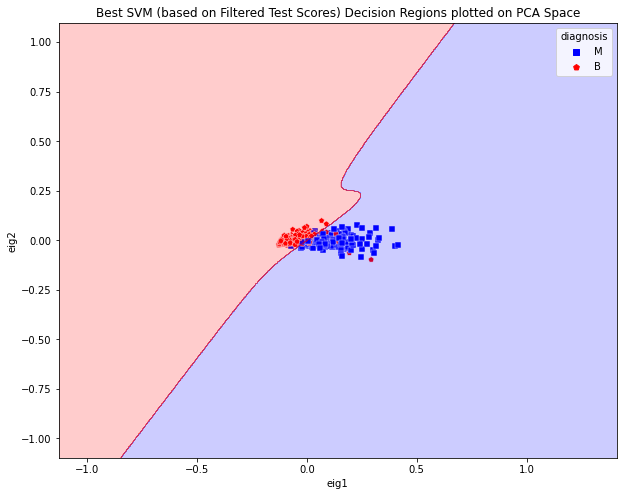

In [14]:
#PCA Analysis
pca = PCA(n_components = 2)
print("bestDF:", bestDF)
x = bestDF.values
print(x)
pca.fit(x)
print('Components using Scikit-learn =')
print(pca.singular_values_)
print(pca.components_)
xP = pca.transform(x)
currentDFPCA = pd.DataFrame(data = xP, columns = ['eig1', 'eig2'])

#print(dfLabels)
X = currentDFPCA
Y = dfLabels # Labels

# Plotting decision regions
X = X.to_numpy()
#print("X:", X)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 #Compute boundaries of painting space
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/1000),
                    np.arange(y_min, y_max, (y_max-y_min)/1000)) #tesselation 0.1 - resolution


f, ax = plt.subplots(figsize=(10, 8))
print(np.c_[xx.ravel(), yy.ravel()].shape)
model.fit(bestDF,dfLabels)
Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])) # Predicting after inversing the PCA
Z = Z.reshape(xx.shape)

# Defining the colors to use
colors=['blue', 'red']
markers = ['s', 'p']
cmap = ListedColormap(colors)

currentDFPCA['diagnosis'] = diagnosis

# Plotting
#print(currentDFPCA.head())
ax = sns.scatterplot(data=currentDFPCA, x='eig1', y='eig2', hue = "diagnosis", palette=colors, style="diagnosis", markers=markers)
ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap) # Paint between boarders
ax.set_title('Best SVM (based on Filtered Test Scores) Decision Regions plotted on PCA Space')
plt.show()
f.savefig("Decision Regions for SVM with Poly")